# Neural Network predictions

### Authors: [Natalí S. M. de Santi](https://natalidesanti.github.io/) and [Christopher Lovell](https://www.christopherlovell.co.uk/)

In this notebook we are going to see how to build a **Neural Network** to predict some galaxy properties, based in some halo properties.

## 0) Necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import seaborn as sns
from keras import models
from keras import layers
from keras import regularizers
import os
from scipy.stats import gaussian_kde
from numpy.random import seed
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import set_random_seed
from numpy.random import seed

## 1) Reading the data

We will work with the catalogs generated with `handling_data.ipynb`.

In [2]:
# Load the data in this way if you have it in the directory
df_train = pd.read_csv('../data/train-halos_and_gals.csv')
df_test = pd.read_csv('../data/test-halos_and_gals.csv')

Using:
* halos: mass, radius, velocity modulus

To predict
* galaxies: stellar masses

\begin{equation}
 \{ M_h, R_h, V_h \} \Rightarrow M_{\star}
\end{equation}

In [3]:
x_train = np.array([df_train['M_h'], df_train['R_h'], df_train['V_h']]).T
x_test = np.array([df_test['M_h'], df_test['R_h'], df_test['V_h']]).T

y_train = np.array([df_train['M_g']]).T
y_test = np.array([df_test['M_g']]).T

In [4]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1211, 3), (303, 3), (1211, 1), (303, 1))

## 2) Pre-processing the data

We will do the following transformation
\begin{equation}
 data \Rightarrow \frac{(data - mean)}{std}
\end{equation}

In [5]:
#Taking mean and std
mean_data = np.mean(x_train, axis = 0)
std_data = np.std(x_train, axis = 0)
mean_data, std_data

(array([10.72031404, -6.69246455,  2.14441201]),
 array([0.57831041, 0.19277028, 0.24073891]))

In [6]:
x_train -= mean_data
x_train /= std_data
x_test -= mean_data
x_test /= std_data

## 3) Neural Networks

A **neural network** is a collection of _nodes_ (neurons) that are arranged in a series of **layers**:

![](https://www.tibco.com/sites/tibco/files/media_entity/2021-05/neutral-network-diagram.svg)

Each connection is responsible to give a weight: $\omega_i a_i$ and each layer is a summarization of them, plus a bias $b$, according too:
\begin{equation}
 b_{\mu} + \sum_{\nu} W_{\mu \nu} a_{\nu} .
\end{equation}
Besides, we have another numeric transformation called **activation function**, responsible to perform a non linear transformation of the values of each layer
\begin{equation}
 y_{\mu} = f \left( b_{\mu} + \sum_{\nu} W_{\mu \nu} a_{\nu} \right) ,
\end{equation}
that can assume different forms:

![](https://miro.medium.com/max/1200/1*ZafDv3VUm60Eh10OeJu1vw.png)

During the **training process** these _weights_ are adjusted through **epochs** in order to minimize the difference between the network predictions $y_{pred}$, and the target values $y_{target}$ through the minimization of a **loss function** (that also can assume different forms). In this tutorial we are going to use the **Mean Squared Error** (**MSE**)
\begin{equation}
 MSE = \frac{1}{m} \sum_{i = 1}^m (y_{pred} - y_{target})^2 ,
\end{equation}

### 3.1. Defining the model

First, defining the **random seed** to get reproducible results

In [7]:
set_random_seed(42)
seed(42)

Let's define a simple standard model according too:

In [8]:
def base_model():
    model = models.Sequential() 
    model.add(layers.Dense(16, activation = 'relu', input_shape = (x_train.shape[1],)))
    model.add(layers.Dense(8, activation = 'relu'))
    model.add(layers.Dense(1))
    
    print(model.summary())
    
    model.compile(optimizer = 'Adam', loss = 'mse')
    
    return model

Here you can visualize the model and their details

In [9]:
my_model = base_model()
my_model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,369
Trainable params: 2,369
Non-trainable params: 0
_________________________________________________________________
None


### 3.2. Fitting the model

The learning process is made by the `fit` function

In [10]:
#Fitting data
no_epochs = 100
batch_size = 100
validation_split = 0.2
history = my_model.fit(x_train, y_train, epochs = no_epochs, 
                       batch_size = batch_size, 
                       validation_split = validation_split, verbose = False)
history

To see if we don't have over/under fitting we can analyse the validation and training losses

In [11]:
train_loss = history.history['loss']
train_val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

Text(0.5, 0, 'Epochs')

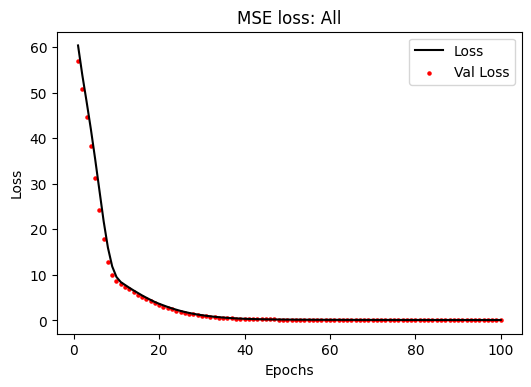

In [12]:
plt.figure(dpi=100)
plt.plot(epochs, train_loss, color = 'black',label = 'Loss')
plt.scatter(epochs, train_val_loss, s = 5, color = 'red', label = 'Val Loss')
plt.legend()  
plt.title('MSE loss: All')
plt.ylabel('Loss')
plt.xlabel('Epochs')

### 3.3. Doing the predictions

The predictions are done using the `predict` function

In [13]:
#Prediction
prediction = my_model.predict(x_test)

10/10 [==============================] - 0s 1ms/step


### 3.4. Performance

#### a) We check the final performance taking a look of some metric computed over the predictions

In [14]:
#Scores
MSE = mean_squared_error(prediction, y_test)
MSE

0.0842410711185824

#### b) Visualizing the results

Scatter plot

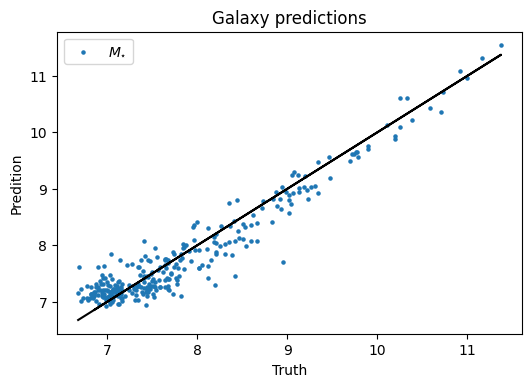

In [15]:
plt.figure(dpi = 100)
plt.title('Galaxy predictions')
plt.scatter(y_test[:, 0], prediction[:, 0], s = 5, color = 'C0', label = '$M_{\star}$')
plt.xlabel(r'Truth')
plt.plot(y_test[:, 0], y_test[:, 0], color = 'black')
plt.ylabel(r'Predition')
plt.legend()

Histogram

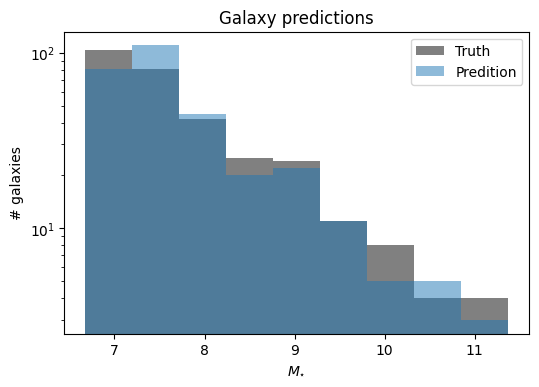

In [16]:
plt.figure(dpi = 100)
plt.title('Galaxy predictions')
bins = np.linspace(np.min(y_test[:, 0]), np.max(y_test[:, 0]), 10)
plt.hist(y_test[:, 0], bins = bins, color = 'gray', label = 'Truth')
plt.hist(prediction[:, 0], bins = bins, color = 'C0', alpha = 0.5, label = 'Predition')
plt.xlabel(r'$M_{\star}$')
plt.ylabel(r'# galaxies')
plt.legend()
plt.yscale('log')

Let's try to do better, but first:

## 4. YOUR TURN

Try to create a NN to:

Using:
* halos: mass, radius, velocity modulus

To predict
* 1) galaxies: SFR
* 2) galaxies: color
* 3) galaxies: stellar mass, SFR, color

Try to think in which lines of code you need to change!
Are just the lines corresponding to the predictions?
Are there any issues related to dimensions then?